## Visualize the entropy of  the trained P_lambda and pi_theta


In [1]:
import sqlite3
import numpy as np
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import argparse, os

import seaborn as sns
from prettytable import PrettyTable

In [2]:
logdir = '/tmp-network/user/tparshak'

# 0:test_ce_r,1:test_ce_pi,2:test_ce_pl,3:train_l1_pl,4:theor_ent,5:tstamp,
# 6:lambd,7:mfeat_pl,8:plambda_time,9:motif,10:train_reg,11:feat,12:n,13:ds_size,14:job
with sqlite3.connect(os.path.join(logdir,'r_plambda_distill_pitheta.db')) as conn:
    cur = conn.cursor()
    cur.execute('SELECT * FROM results')
    d_pl = cur.fetchall()
#for tpl in d_pl:
#    print(tpl)

In [3]:
def load_data_motif(n, sz, motif, ds_type, nmotif):
    ds = ""
    # input: <bos> binary string <eos>
    # 3 {0,1}^n 2
    if nmotifs == 1:
        data_file = os.path.join(logdir, 'data/pfsa_%d_%s'%(n, motif),"%s.txt"%ds_type)
    else:
        data_file = os.path.join(logdir, 'data/pfsa_%d_%s'%(n-1, motif),"%s.txt"%ds_type)
    
    with open(data_file, "r") as file:
        for line in file:
            #assert motif in line
            ds += line.strip()
            #print(line.strip())
            if len(ds)>=sz*n:
                break
    original = ''.join(c+' ' for c in ds[:sz*n]).strip()
    original = np.fromstring(original, dtype=int, sep=' ')
    original = original.reshape((original.shape[0]//n, n)).transpose()
    
    for i in range(original.shape[1]):
        res = ''.join([str(original[j,i]) for j in range(original.shape[0])])
        #assert flag
    
    dataset = (np.ones((n+2, original.shape[1]))).astype(int)
    dataset[1:-1] = original
    dataset[0] = dataset[0]*3
    dataset[-1] = dataset[-1]*2
    assert dataset.shape[1] >= sz
    ds = dataset
    return ds

def oracle_features(s, motifs, feat, nmotifs, n):
    # s: seq_len x 1
    # output: [ nfeat ]
    # (motif, supermotif, submotif__2, 1st bit==0, 10101_len_m, 1001001_le_m_2, 00110011_len_m__2)
    out = []
    idx = min(1, len(s)-1)
    nfeat = sum([sum([int(e!='0') for e in el]) for el in feat])
    
    i = 0
    for j in range(len(feat)):
        if feat[j] == '1':
            if j < len(feat)-4:
                if nmotifs == 1:
                    if j==0:
                        # motif
                        out += [1 - int(motifs[i] in s)]
                    elif j==1:
                        # supermotif
                        motif_j = motifs[i] + '0'*1
                        out += [1 - int(motif_j in s)]
                    elif j==2:
                        # submotif
                        motif_j = motifs[i][:len(motifs[i])//2]
                        out += [1 - int(motif_j in s)]
                elif nmotifs == 2:
                    if j in [0,2]:
                        # motif
                        out += [1 - int(motifs[max(0, j-1)] in s)]
                    elif j in [1,3]:
                        # submotif
                        motif_j = motifs[max(0, j-2)][:len(motifs[max(0, j-2)])//2]
                        out += [1 - int(motif_j in s)]
            else:
                if j == len(feat)-4:
                        # first bit
                        out += [1 - int(s[idx]=='1')]
                # distractor
                elif j == len(feat)-3:
                    pref = '10101'
                    motif_j = (pref*n)[:len(motifs[i])]
                    out += [1 - int(motif_j in s)]
                elif j == len(feat)-2:
                    pref = '1001001'
                    motif_j = (pref*n)[:len(motifs[i])+2]
                    out += [1 - int(motif_j in s)]
                elif j == len(feat)-1:
                    pref = '00110011'
                    motif_j = (pref*n)[:len(motifs[i])//2]
                    out += [1 - int(motif_j in s)]
        elif feat[j] == 'e':
            out += [get_edit_frc(s, motifs[i])]
        elif feat[j] == 's':
            out += [get_longestsubstr_frc(s, motifs[i])]
        elif feat[j] == 'm':
            out += [get_longestsubstr_frc(s, motifs[i]) + get_edit_frc(s, motifs[i])]
    return out


def get_longestsubstr_frc(s, motif):
    
    n, m = len(s)+1, len(motif)+1
    #assert m<=n
    e = np.zeros((m,n))
    max_lss = 0
    for j in range(1,m):
        for i in range(1,n):
            e_ij = []
            if s[i-1]!=motif[j-1]:
                e[j,i]=0
            else: 
                e[j,i] = 1 + e[j-1,i-1]
            max_lss = max(max_lss, e[j,i])
    return 1-max_lss/len(motif)

def get_edit_frc(s, motif):
    def edit_distance(subs, motif):
        n, m = len(subs)+1, len(motif)+1
        #assert m<=n
        e = np.zeros((m,n))
        e[0,0] = 0
        for j in range(1,m):
            e[j,0]= j
        
        for j in range(1,m):
            for i in range(1,n):
                e_ij = []
                if j>0:
                    e_ij += [e[j-1,i]+1]
                if i>0:
                    e_ij += [e[j,i-1]+1]
                if j>0 and i>0:
                    e_ij += [e[j-1, i-1]+ int(subs[i-1]!=motif[j-1])]
                if e_ij:
                    e[j,i] = min(e_ij)
        return 1.0*min(e[-1,:])
    ed_dist =  edit_distance(s, motif)
    edit_frac = ed_dist/len(motif)
    assert edit_frac<=1
    return edit_frac

    
def get_features(var, motifs, feat, nmotifs, n):
    # returns the results of identifying oracle features in the input binary sequence
    # 0 = feature exists
    # var:      [ seq_len x batch ]
    # output:   [batch x nfeat]
    def var_to_str(a):
        b = []
        for i in range(a.shape[1]):
            b += [''.join([str(el) for el in a[:,i]])]
        return b
    m = motifs[0].split('.')[1]
    x = var_to_str(var)
    out = []
    for b in x:
        out += [oracle_features(b, [m], feat, nmotifs, n)]
    train_feat = np.array(out).mean(0)
    print(train_feat.shape, feat, train_feat[0])
    return train_feat

    

In [4]:
true_feats = np.load('true_feats.npy').item()

In [5]:
motifs = ['m.10001011111000', 'mam.100010100011', 'mam.1000101111100011', 
          'mam.10001011111000', 'm.10001010001',
         'm.01011101101', 'mam.01011101101', 'm.001001100111',
         'mam.001001100111', 'm.1011100111001', 'mam.1011100111001', 'm.0111010000011101']
feats = [ '1001111','1011111','0111111', 's001111', 'm001111']
#feats = [ 's001111']

In [7]:
#np.save('true_feats.npy', true_feats)

In [9]:
#r_freqs[timestamp+'_'+m+'_'+tr] = (freq, avg_len)
r_freqs = np.load(os.path.join(logdir,'exp_gams/r_freqs.npy')).item()

In [10]:
# 0:test_ce_r,1:test_ce_pi,2:test_ce_pl,3:train_l1_pl,4:theor_ent,5:tstamp,
# 6:lambd,7:mfeat_pl,8:plambda_time,9:motif,10:train_reg,11:feat,12:n,13:ds_size,14:job

data_pl = list(zip(*d_pl))
ds_range = [500, 1000, 5000, 10000, 15000, 20000, 30000, 50000, 100000]
train_r = ['rs', 'snis_mix', 'snis_r', 'rs_c', 'snis_r_c']
#feats = ['1011111', '0111111']
seq_len = [30, 31, 100]
motifs = ['m.10001011111000', 'mam.100010100011', 'mam.1000101111100011', 
          'mam.10001011111000', 'm.10001010001',
         'm.01011101101', 'mam.01011101101', 'm.001001100111',
         'mam.001001100111', 'm.1011100111001', 'mam.1011100111001', 'm.0111010000011101']
feats = [ '1001111','1011111','0111111', 's001111', 'm001111']
 
all_motifs = {n_i:set() for n_i in seq_len}
for i in range(len(data_pl[0])):
    n_i = data_pl[12][i]
    m = data_pl[9][i]
    m = '.'.join(m.split('.')[:2])
    all_motifs[n_i].add(m)
    
print(all_motifs)
dict_pl = {n_i:{m:{f:{i:{tr:[] for tr in train_r} for i in ds_range} for f in feats} for m in all_motifs[n_i]}for n_i in seq_len}
for i in range(len(d_pl)):
    n_i = data_pl[12][i]
    # n -> motif -> feat -> ds_size -> train_reg -> 
    #[0:test_ce_r,1:test_ce_pi,2:test_ce_pl,3:train_l1_pl,4:theor_ent,5:tstamp,6:lambd,7:mfeat_pl,8:plambda_time,
    #                                 9:job,10:l1_diff,11:r_feat]
    m = data_pl[9][i]
    m = '.'.join(m.split('.')[:2])
    ds = data_pl[13][i]
    f  = data_pl[11][i]
    if (not m in motifs) or (not f in feats): continue
    tr = data_pl[10][i]
    timestamp = '_'.join(data_pl[5][i].split('_')[:2])
    
    mfeat = [float(el.strip()) for el in data_pl[7][i][1:-1].split(',')]
    tfeat = true_feats[m+'.'+f]
    l1_diff_all = np.abs(tfeat- np.array(mfeat))
    
    l1_diff = l1_diff_all.sum()
    
    if timestamp+'_'+m+'_'+tr in r_freqs:
        r_freq = r_freqs[timestamp+'_'+m+'_'+tr][0]
    elif len(data_pl[5][i].split('_'))>4:
        r_freq = float(data_pl[5][i].split('_')[4])
    else:
        r_freq='-'
     
    dict_pl[n_i][m][f][ds][tr] += [list(d_pl[i][:3])+ [l1_diff]+list(d_pl[i][4:9])+[d_pl[i][14], l1_diff_all, r_freq]]


{30: {'m.10001010001', 'm.10001011111000', 'm.001001100111', 'mam.100010100011', 'mam.1011100111001', 'mam.1000101111100011', 'mam.001001100111', 'm.01011101101', 'mam.10001011111000', 'mam.01011101101', 'm.1011100111001'}, 31: {'m1m2.100010111110001', 'm1m2.100010111110'}, 100: {'m.0111010000011101'}}


In [14]:
ent_motifs = {30:{'mam.100010100011':16.282530254126048/31, 'mam.1000101111100011':13.57540128031525/31,
                    'm.10001010001':16.15303451776991/31,'m.10001011111000':13.923144487457433/31,
                 'mam.10001011111000':14.935250784153713/31, 'm.01011101101':16.1633538708637/31, 
                 'm.001001100111':15.420728378322668/31,'m.1011100111001':14.6736907/31, 'mam.01011101101':16.950563779/31,
                 'mam.001001100111':16.2827152768/31, 'mam.1011100111001':15.61062622/31, 'm.1000101000101':14.66329972621143/31}, 
                  100:{'m.0111010000011101':62.665668876452344/101}}

z_motifs = {30:{'mam.100010100011':0.0046360, 'mam.1000101111100011':0.00022888,
                    'm.10001010001':0.00964437,'m.10001011111000':0.0010371580,
                 'mam.10001011111000':0.001037158, 'm.01011101101':0.0097444, 
                 'm.001001100111':0.004637, 'm.1011100111001':0.002196863, 'mam.01011101101':0.00974440,
                 'mam.001001100111':0.004637, 'mam.1011100111001':0.002196863, 'm.1000101000101':0.0021741539239883423}, 
            100:{'m.0111010000011101':0.0012952530732785747}}


In [15]:
ent_motifs[100]['m.0111010000011101']

0.6204521670935875

# Paper plots

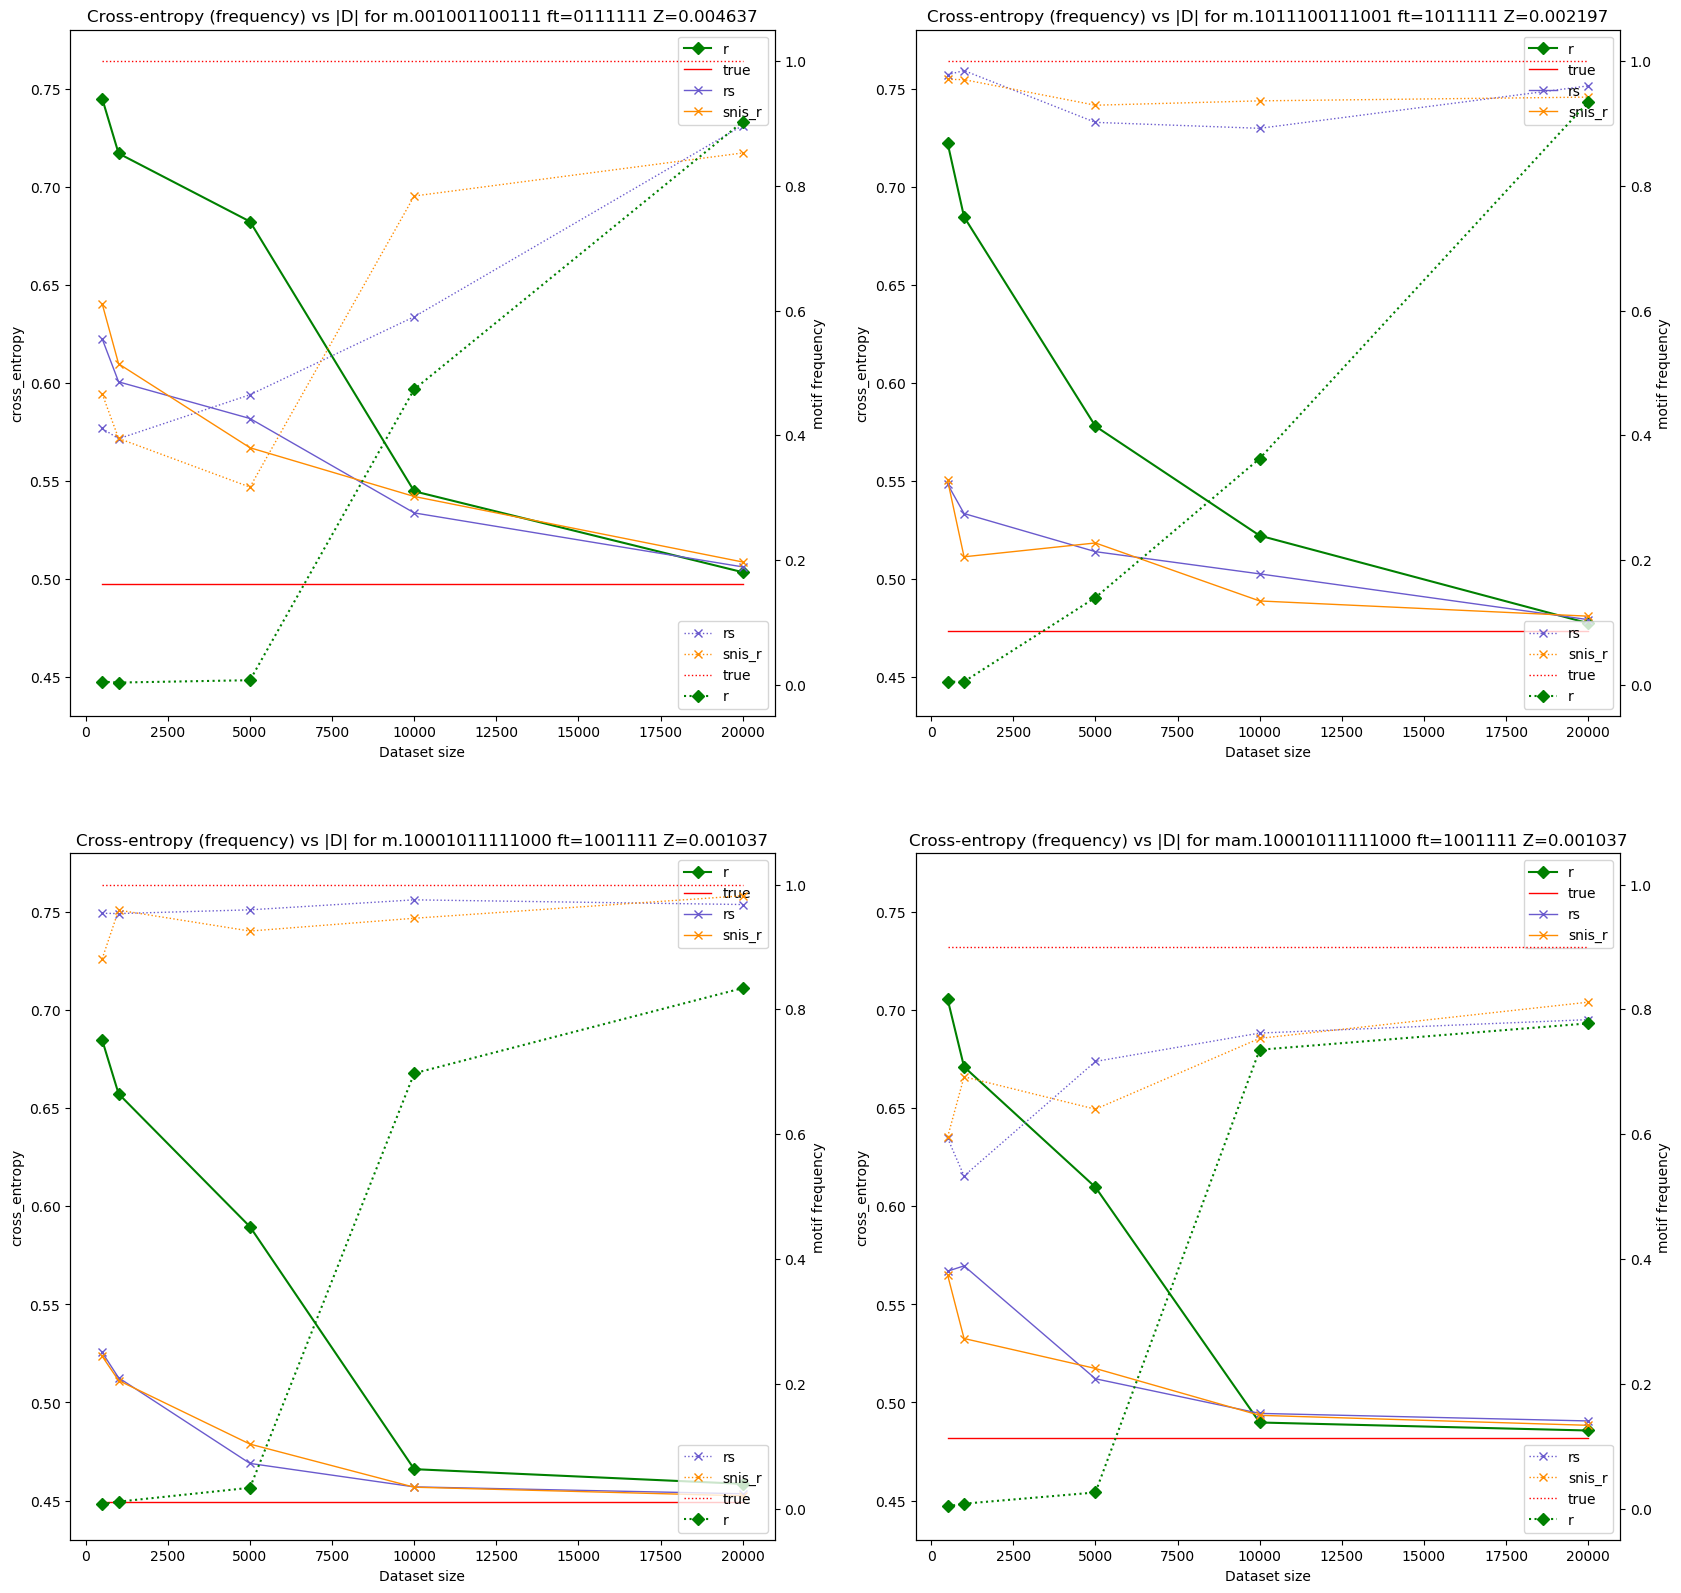

In [16]:
ms_feats = [['m.001001100111','0111111'], ['m.1011100111001','1011111'],
            ['m.10001011111000','1001111'], ['mam.10001011111000','1001111']]
           #['mam.1000101111100011', '1001111']]
fig=plt.figure(figsize=(10*len(ms_feats)//2, 20), dpi= 100, facecolor='w', edgecolor='k')

n = 30
train_r = ['rs', 'snis_r']
ds_range = [500, 1000, 5000, 10000, 20000]

def get_freq(s):
    return float(s.split('_')[2])

i=0
for m, feat in ms_feats:
        #plt.subplot(1, len(ms_feats), i+1)
        ax1 = fig.add_subplot(2, len(ms_feats)//2, i+1)
        
        # n -> motif -> feat -> ds_size -> train_reg -> 
        #[0:test_ce_r,1:test_ce_pi,2:test_ce_pl,3:train_l1_pl,4:theor_ent,5:tstamp,6:lambd,7:mfeat_pl,8:plambda_time,
        #                                 10:job,10:l1_diff]
            
        ce_hybr = {t:np.array([dict_pl[n][m][feat][ds][t][0][1] for ds in ds_range])
                             for t in train_r}
        ce_r = [np.array([dict_pl[n][m][feat][ds][t][0][0] for t in train_r]) 
                   for ds in ds_range] 

        df1 = {'x': ds_range, 
                            'rs':  ce_hybr['rs'], 
                            #snis_mix': ce_hybr[1], 
                            'snis_r': ce_hybr['snis_r'],
                            'ce_r': ce_r,
                            'theor': np.array([ent_motifs[n][m]]*len(ds_range))}

        #plt.errorbar(df1['x'], np.array(df1['ce_r']).mean(1), yerr=np.array(df1['ce_r']).std(1), 
        #                 fmt='o', capthick=2, ecolor='g',color='g', capsize=5,label='r')
        ax1.plot(df1['x'], np.array(df1['ce_r']).mean(1),  
                         marker='D', color='g', label='r')
        ax1.plot( df1['x'], df1['theor'], marker='', color='red', linewidth=1,label='true')
        ax1.plot( df1['x'], df1['rs'], marker='x', color='slateblue', linewidth=1,label='rs')
        #plt.plot( df1['x'], df1['snis_mix'], marker='', color='olive', linewidth=1,label='snis_mix')
        ax1.plot( df1['x'], df1['snis_r'], marker='x', color='darkorange', linewidth=1,label='snis_r')
        ax1.set_xlabel('Dataset size')
        ax1.set_ylabel('cross_entropy')
        ax1.set_title('Cross-entropy (frequency) vs |D| for %s ft=%s Z=%.6f'%(m, feat,z_motifs[n][m]))
        ax1.legend()
        ax1.set_ylim(0.43, 0.78)
        
        ax2 = ax1.twinx()
        
        freq_hybr = {t:np.array([get_freq(dict_pl[n][m][feat][ds][t][0][5]) for ds in ds_range])
                             for t in train_r}
        
        freq_r = [np.array([dict_pl[n][m][feat][ds][t][0][11] for t in train_r]) 
                   for ds in ds_range] 
        
        if 'mam' in m:
            theor = np.array([0.9]*len(ds_range))
        else:
            theor = np.array([1.0]*len(ds_range))

        df1 = {'x': ds_range, 
                            'rs':  freq_hybr['rs'], 
                            #'snis_mix': freq_hybr[1], 
                            'snis_r': freq_hybr['snis_r'],
                            'theor': theor,
                            'r_freq':freq_r}

        ax2.plot( df1['x'], df1['rs'], marker='x', color='slateblue', linewidth=1,label='rs',  linestyle=':')
        #plt.plot( df1['x'], df1['snis_mix'], marker='', color='olive', linewidth=1,label='snis_mix')
        ax2.plot( df1['x'], df1['snis_r'], marker='x', color='darkorange', linewidth=1,label='snis_r',  linestyle=':')
        ax2.plot( df1['x'], df1['theor'], marker='', color='red', linewidth=1,label='true',  linestyle=':')
        ax2.plot(df1['x'], np.array(df1['r_freq']).mean(1), marker='D', color='g', label='r',  linestyle=':')

        #ax2.xlabel('Dataset size')
        ax2.set_ylabel('motif frequency')
        #ax2.title('Motif freq vs |D| for %s ft=%s Z=%.6f'%(m, feat,z_motifs[n][m]))
        ax2.legend()
        ax2.set_ylim(-0.05, 1.05)

        i += 1
        
fig.savefig("ce_freq.pdf", bbox_inches='tight')

## Statistics

In [214]:
# n -> motif -> feat -> ds_size -> train_reg -> 
#[0:test_ce_r,1:test_ce_pi,2:test_ce_pl,3:train_l1_pl,4:theor_ent,
# 5:tstamp,6:lambd,7:mfeat_pl,8:plambda_time,
# 10:job,10:l1_diff,11:r_feat]

n = 30
train_r = ['rs']
ds_range = [500, 1000, 5000, 10000, 20000]

ms = ['m.10001010001','m.01011101101','m.001001100111','m.1011100111001','m.10001011111000']
mams = ['mam.01011101101', 'mam.001001100111', 'mam.1011100111001', 
      'mam.100010100011', 'mam.10001011111000']
feats = [ '1001111','1011111','0111111']

ce_ratios = {t+str(ds):[] for t in train_r for ds in ds_range}
for motifs, fts in [(ms, feats), (mams, ['1001111'])]:
    for ds in ds_range:
        for t in train_r:
            for m in motifs:
                for feat in fts:
                    ce_ratios[t+str(ds)] += [dict_pl[n][m][feat][ds][t][0][0]/dict_pl[n][m][feat][ds][t][0][1]]
                    
                    #ent_motifs[n][m]
            #print(np.array(ce_ratios[t+str(ds)]).shape)
            ce_ratios[t+str(ds)] = [np.round(np.array(ce_ratios[t+str(ds)]).mean(), decimals=2), 
                                    np.round(np.array(ce_ratios[t+str(ds)]).std(), decimals=2)]
    print(motifs)
    for el in ce_ratios.items():
        print(el)
    ce_ratios = {t+str(ds):[] for t in train_r for ds in ds_range}

['m.10001010001', 'm.01011101101', 'm.001001100111', 'm.1011100111001', 'm.10001011111000']
('rs500', [1.24, 0.07])
('rs1000', [1.24, 0.07])
('rs5000', [1.18, 0.08])
('rs10000', [1.08, 0.1])
('rs20000', [0.99, 0.01])
['mam.01011101101', 'mam.001001100111', 'mam.1011100111001', 'mam.100010100011', 'mam.10001011111000']
('rs500', [1.23, 0.03])
('rs1000', [1.21, 0.03])
('rs5000', [1.16, 0.05])
('rs10000', [1.02, 0.03])
('rs20000', [0.99, 0.0])


In [215]:
# ce(pi_theta)/true_ce
n = 30
train_r = ['rs']
ds_range = [500, 1000, 5000, 10000, 20000]

ms = ['m.10001010001','m.01011101101','m.001001100111','m.1011100111001','m.10001011111000']
mams = ['mam.01011101101', 'mam.001001100111', 'mam.1011100111001', 
      'mam.100010100011', 'mam.10001011111000']
feats = [ '1001111','1011111','0111111']

ce_ratios = {t+str(ds):[] for t in train_r for ds in ds_range}
for motifs, fts in [(ms, feats), (mams, ['1001111'])]:
    for ds in ds_range:
        for t in train_r:
            for m in motifs:
                for feat in fts:
                    ce_ratios[t+str(ds)] += [dict_pl[n][m][feat][ds][t][0][1]/ent_motifs[n][m]]
                    
                    #ent_motifs[n][m]
            #print(np.array(ce_ratios[t+str(ds)]).shape)
            ce_ratios[t+str(ds)] = [np.round(np.array(ce_ratios[t+str(ds)]).mean(), decimals=2), 
                                    np.round(np.array(ce_ratios[t+str(ds)]).std(), decimals=2)]           

    print(motifs)
    for el in ce_ratios.items():
        print(el)
    ce_ratios = {t+str(ds):[] for t in train_r for ds in ds_range}

['m.10001010001', 'm.01011101101', 'm.001001100111', 'm.1011100111001', 'm.10001011111000']
('rs500', [1.19, 0.07])
('rs1000', [1.16, 0.07])
('rs5000', [1.09, 0.05])
('rs10000', [1.04, 0.02])
('rs20000', [1.02, 0.01])
['mam.01011101101', 'mam.001001100111', 'mam.1011100111001', 'mam.100010100011', 'mam.10001011111000']
('rs500', [1.16, 0.03])
('rs1000', [1.14, 0.03])
('rs5000', [1.08, 0.04])
('rs10000', [1.04, 0.03])
('rs20000', [1.02, 0.0])


In [218]:
# freq
n = 30
train_r = ['rs']
ds_range = [500, 1000, 5000, 10000, 20000]

ms = ['m.10001010001','m.01011101101','m.001001100111','m.1011100111001','m.10001011111000']
mams = ['mam.01011101101', 'mam.001001100111', 'mam.1011100111001', 
      'mam.100010100011', 'mam.10001011111000']
feats = [ '1001111','1011111','0111111']

ce_ratios = {t+str(ds):[] for t in train_r for ds in ds_range}
for motifs, fts in [(ms, feats), (mams, ['1001111'])]:
    for ds in ds_range:
        for t in train_r:
            for m in motifs:
                for feat in fts:
                    tmp = dict_pl[n][m][feat][ds][t][0][5].split('_')
                    freq, l = '-', '-'
                    if len(tmp)>2:
                        freq = np.round(float(tmp[2]), decimals=2)
                    else:
                        continue
                    ce_ratios[t+str(ds)] += [freq/dict_pl[n][m][feat][ds][t][0][11]]
                    
                    #ent_motifs[n][m]
            if t+str(ds) == 'rs1000':
                print(ce_ratios[t+str(ds)])
            #print(np.array(ce_ratios[t+str(ds)]).shape)
            ce_ratios[t+str(ds)] = [np.round(np.array(ce_ratios[t+str(ds)]).min(), decimals=2), 
                                    np.round(np.array(ce_ratios[t+str(ds)]).max(), decimals=2)] 
    print(motifs)
    for el in ce_ratios.items():
        print(el)
    ce_ratios = {t+str(ds):[] for t in train_r for ds in ds_range}

[81.73913043478261, 70.0, 30.000000000000004, 76.8, 75.38461538461539, 23.870967741935484, 242.5, 653.3333333333333, 130.0, 265.7142857142857, 140.0, 77.77777777777779, 118.74999999999999, 72.5925925925926, 40.0]
['m.10001010001', 'm.01011101101', 'm.001001100111', 'm.1011100111001', 'm.10001011111000']
('rs500', [32.0, 392.0])
('rs1000', [23.87, 653.33])
('rs5000', [3.59, 206.67])
('rs10000', [0.89, 196.0])
('rs20000', [0.81, 1.76])
[26.285714285714285, 233.33333333333331, 193.33333333333331, 106.66666666666667, 132.5]
['mam.01011101101', 'mam.001001100111', 'mam.1011100111001', 'mam.100010100011', 'mam.10001011111000']
('rs500', [59.26, 433.33])
('rs1000', [26.29, 233.33])
('rs5000', [7.32, 130.0])
('rs10000', [1.0, 4.97])
('rs20000', [0.85, 1.04])


In [75]:
ce_ratios = {str(ds):[] for ds in ds_range}
for motifs, fts in [(ms, feats), (mams, ['1001111'])]:
    for ds in ds_range:
        for t in train_r:
            for m in motifs:
                for feat in fts:
                    ce_ratios[str(ds)] += [dict_pl[n][m][feat][ds][t][0][0]/dict_pl[n][m][feat][ds][t][0][1]]

        #print(np.array(ce_ratios[str(ds)]).shape)
        ce_ratios[str(ds)] = np.array(ce_ratios[str(ds)]).mean()
    print(motifs)
    for el in ce_ratios.items():
        print(el)
    ce_ratios = {str(ds):[] for ds in ds_range}


['m.10001010001', 'm.01011101101', 'm.001001100111', 'm.1011100111001', 'm.10001011111000']
('500', 1.2372880046027155)
('1000', 1.2339075005277678)
('5000', 1.1874898231056645)
('10000', 1.0741186900252901)
('20000', 1.003246871249985)
['mam.01011101101', 'mam.001001100111', 'mam.1011100111001', 'mam.100010100011', 'mam.10001011111000']
('500', 1.2244510612797461)
('1000', 1.2129129337055664)
('5000', 1.1723577135237122)
('10000', 1.059039804415695)
('20000', 0.9913039074800155)


In [78]:
# ce(pi_theta)/true_ce
ce_ratios = {str(ds):[] for ds in ds_range}
for motifs, fts in [(ms, feats), (mams, ['1001111'])]:
    for ds in ds_range:
        for t in train_r:
            for m in motifs:
                for feat in fts:
                    ce_ratios[str(ds)] += [dict_pl[n][m][feat][ds][t][0][1]/ent_motifs[n][m]]
        #print(np.array(ce_ratios[str(ds)]).shape)
        ce_ratios[str(ds)] = np.array(ce_ratios[str(ds)]).mean()
    print(motifs)
    for el in ce_ratios.items():
        print(el)
    ce_ratios = {str(ds):[] for ds in ds_range}


['m.10001010001', 'm.01011101101', 'm.001001100111', 'm.1011100111001', 'm.10001011111000']
('500', 1.1999260024655198)
('1000', 1.1617556120777535)
('5000', 1.1050445899697452)
('10000', 1.056494744331952)
('20000', 1.0279834594978015)
['mam.01011101101', 'mam.001001100111', 'mam.1011100111001', 'mam.100010100011', 'mam.10001011111000']
('500', 1.1467860568495225)
('1000', 1.1292696347879159)
('5000', 1.0806733747992552)
('10000', 1.0444561771362788)
('20000', 1.0161587295630616)


In [77]:
# n -> motif -> feat -> ds_size -> train_reg -> 
#[0:test_ce_r,1:test_ce_pi,2:test_ce_pl,3:train_l1_pl,4:theor_ent,
# 5:tstamp,6:lambd,7:mfeat_pl,8:plambda_time,
# 10:job,10:l1_diff,11:r_feat]
freq_hybr = {t:np.array([get_freq(dict_pl[n][m][feat][ds][t][0][5]) for ds in ds_range])
                             for t in train_r}
        
freq_r = [np.array([dict_pl[n][m][feat][ds][t][0][11] for t in train_r]) 
                   for ds in ds_range]

freq_ratios = {str(ds):[] for ds in ds_range}
for motifs, fts in [(ms, feats), (mams, ['1001111'])]:
    for ds in ds_range:
        for t in train_r:
            for m in motifs:
                for feat in fts:
                    tmp = dict_pl[n][m][feat][ds][t][0][5].split('_')
                    freq, l = '-', '-'
                    if len(tmp)>2:
                        freq = np.round(float(tmp[2]), decimals=2)
                    else:
                        continue
                    freq_ratios[str(ds)] += [freq/dict_pl[n][m][feat][ds][t][0][11]]
        #print(np.array(freq_ratios[str(ds)]).shape)
        freq_ratios[str(ds)] = np.array(freq_ratios[str(ds)]).mean()
    print(motifs)
    for el in freq_ratios.items():
        print(el)
    freq_ratios = {str(ds):[] for ds in ds_range}

['m.10001010001', 'm.01011101101', 'm.001001100111', 'm.1011100111001', 'm.10001011111000']
('500', 161.2977725433608)
('1000', 128.95254656239442)
('5000', 51.79281845725731)
('10000', 16.219589796004094)
('20000', 2.8402650225257293)
['mam.01011101101', 'mam.001001100111', 'mam.1011100111001', 'mam.100010100011', 'mam.10001011111000']
('500', 221.15002405002406)
('1000', 111.79477189477188)
('5000', 49.51536392615351)
('10000', 17.12763724124569)
('20000', 0.9790789831804197)


In [160]:
n = 30; m = 'm.10001011111000'; ds = 5000; f = '1001111'; tr = 'rs'
print(dict_pl[n][m][f][ds][tr])
print(ent_motifs[n][m])

[[0.5646450519561768, 0.4689084589481354, 0.4662000834941864, 0.04167740456000019, 0.44913369314378815, '05m27d_144653104726_0.9595_30.7_0.045_27.8', '[-10.090909, -0.15051788, -0.062074546, 0.0, -0.14176218]', '[0.00054545456, 0.4351818, 0.9996818, 0.9999545, 0.91349995]', 0.4023709797196918, 974270, array([5.4545456e-04, 3.9618200e-02, 1.1820000e-04, 4.5500000e-05,
       1.3500500e-03]), 0.045]]
0.44913369314378815


In [161]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

class RNNModel(nn.Module):
    def __init__(self, ntoken, ninp, nhid, nlayers, dropout=0.5):
        super(RNNModel, self).__init__()
        self.drop = nn.Dropout(dropout)
        
        self.encoder = nn.Embedding(ntoken, ninp)
        one_hot_vecs = np.array([[1,0,0], [0,1,0], [0,0,1], [0,0,0], [0,0,0]])
        self.encoder.weight.data.copy_(torch.from_numpy(one_hot_vecs))
        self.freeze_layer(self.encoder)
        
        self.rnn = nn.LSTM(ninp, nhid, nlayers, dropout=dropout) 
        # <bos> is not in the output vocabulary       
        self.decoder = nn.Linear(nhid, ninp)

        self.init_weights()
        
        self.nhid = nhid
        self.nlayers = nlayers
    
    def freeze_layer(self, layer):
        for param in layer.parameters():
            param.requires_grad = False

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.fill_(0)
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, input, hidden, len_inp, mask):
        emb = self.drop(self.encoder(input))
        output, hidden = self.rnn(emb, hidden)
        output = self.drop(output) # [seq_len ,batch, nhid]
        # [seq_len*batch, ntok]
        decoded = self.decoder(output.view(output.size(0)*output.size(1), output.size(2)))
        decoded = torch.mul(decoded.view(output.size(0), output.size(1), decoded.size(1)), mask)
        return decoded, hidden

    def init_hidden(self, bsz):
        weight = next(self.parameters()).data
        return (Variable(weight.new(self.nlayers, bsz, self.nhid).zero_()),
                    Variable(weight.new(self.nlayers, bsz, self.nhid).zero_()))


In [ ]:
timestamp = tmpsmt = '_'.join(dict_pl[n][m][f][ds][tr][0][5].split('_')[:2])
log_dir = '/home/tparshak/jupyter_code/exp_gams/runs/chpt_%s'%(timestamp)
model_r = torch.load(os.path.join(log_dir,'chpt_%s_r.pt'%(timestamp)))
model_r.cuda()

class Args:       # =1= short motif, =2= long motif
    n=30
    train='rs'    # =rs= rejection sampling
    feat = ['1001111']
    motif = 4


args=Args()
start_symbol = torch.tensor([[3]*10000]).cuda()
PAD = 4
ninp = 3

In [185]:
def sample_lm_vary(model, batch_size_i, max_len=None):
    # output: [ seq_len x batch ]
    
    # [ 1 x batch ]
    # <pad> idx = 4
    if not max_len:
        max_len=args.n*2+1
    out = [(torch.ones(1)*3).cuda().long()]*batch_size_i # contains sequences of variable lenght
    symb = start_symbol[:,:batch_size_i]
    hidden = model.init_hidden(batch_size_i)
    len_inp = torch.ones((batch_size_i), dtype=torch.int64)
    mask = torch.ones((1, batch_size_i, 1)).cuda()
    all_logits = torch.ones((1, batch_size_i, ninp)).cuda()
    
    for i in range(max_len):
        # [1 x batch x ntok]
        logits, hidden = model(symb, hidden, len_inp, mask)[:2]
        probs = softm(logits)
        cat_dist = torch.distributions.Categorical(probs=probs)
        # [ 1 x batch ]
        symb = cat_dist.sample()
        flag = False
        for b in range(batch_size_i):
            if i==0 or (i>0 and out[b][-1] != 2): 
                out[b] = torch.cat((out[b], symb[:1,b]), dim=0)
                flag = True
        all_logits = torch.cat((all_logits, logits), dim=0)
        if not flag:
            break
        
    out = torch.nn.utils.rnn.pad_sequence(out, batch_first=False, padding_value=PAD)   
    # <bos> 010010101 <eos>
    return out, all_logits[1:out.size(0),:,:]

softm = nn.Softmax(dim=2)

def sample_data_inp_targ_vary(model, batch_size_i, max_len=None):
    # padded variable lengths sequences
    # [ seq_len x batch ]
    if not max_len:
        max_len = args.n*2+1
    x, log_pi = sample_lm_vary(model, batch_size_i, max_len)
    len_inp = (x!= PAD).sum(0)
    len_inp, perm_idx = len_inp.sort(0, descending=True)
    len_inp = len_inp - 1
    x = x[:, perm_idx]
    inp = x[:-1,:]

    # [(n+1) x batch]
    targets = x[1:,:] 
    mask_tar = (targets != PAD).unsqueeze(2).float().cuda()   
    len_tar = (targets != PAD).sum(0)
    
    return x, log_pi, inp, len_inp, targets, mask_tar

def cat_variable_length(a, b):
    seq_len = max(a.size()[0], b.size()[0])
    if a.size()[0] < seq_len:
        a = torch.cat((a, torch.ones((seq_len-a.size()[0], a.size(1))).long().cuda()*PAD), dim=0)
    if b.size()[0] < seq_len:
        b = torch.cat((b, torch.ones((seq_len-b.size()[0], b.size(1))).long().cuda()*PAD), dim=0)

    return torch.cat((a,b), dim=1)

In [186]:
def cyclic_distill_r(model, feat, ds_size):
    # q(x)=r(x), Q(x)>=P_lambda(x) for any x 
    # sample from LM: x ~ q(x)
    # accept with probability ro = P_lambda(x)/Q(x)

    nfeat = sum([sum([int(e!='0') for e in el]) for el in feat])
    samples = torch.zeros((args.n+2,0)).long().cuda()
    batch_size_i = 1024
    
    count = 0

    while count < ds_size:            
        #x, inp, len_inp, targets, mask_tar = sample_data_inp_targ(model, batch_size_i)
        x, log_pi, inp, len_inp, target, mask_tar = sample_data_inp_targ_vary(model, batch_size_i)


        samples = cat_variable_length(samples, x)
        count += x.size(1)
        print(np.round(len_inp.float().mean().data.cpu().numpy(),decimals=1))
                   
    # samples [ seq_len x ds_size ]
    return samples[:,:ds_size]

In [187]:
train_data = cyclic_distill_r(model_r, feat, 20000)
train_data = train_data.cpu().numpy()

27.3
28.1
27.7
27.9
28.0
28.0
28.2
27.9
27.5
28.4
27.9
27.6
27.8
28.1
28.1
27.7
27.9
27.6
27.8
27.8


In [188]:
print(train_data.shape)

(34, 20000)


In [189]:
get_features(train_data, [m], feat, 1, n)

(5,) 1001111 0.952


array([0.952  , 0.53125, 0.9998 , 1.     , 0.9109 ])

In [190]:
D = np.load(os.path.join(log_dir,'train_n%d_f%s_m%d.npy'%(n, feat, 4)))

In [191]:
get_features(D, [m], feat, 1, n)

(5,) 1001111 0.0006


array([6.0000e-04, 4.3745e-01, 9.9965e-01, 9.9995e-01, 9.1350e-01])

In [203]:
# n -> motif -> feat -> ds_size -> train_reg -> 
#[0:test_ce_r,1:test_ce_pi,2:test_ce_pl,3:train_l1_pl,4:theor_ent,
# 5:tstamp,6:lambd,7:mfeat_pl,8:plambda_time,
# 10:job,10:l1_diff,11:r_feat]

print(dict_pl[n][m][f][ds][tr][0])
print(ent_motifs[n][m])

[0.5646450519561768, 0.4689084589481354, 0.4662000834941864, 0.04167740456000019, 0.44913369314378815, '05m27d_144653104726_0.9595_30.7_0.045_27.8', '[-10.090909, -0.15051788, -0.062074546, 0.0, -0.14176218]', '[0.00054545456, 0.4351818, 0.9996818, 0.9999545, 0.91349995]', 0.4023709797196918, 974270, array([5.4545456e-04, 3.9618200e-02, 1.1820000e-04, 4.5500000e-05,
       1.3500500e-03]), 0.045]
0.44913369314378815


In [193]:
def sample_from_rnn(model, n, motifs):
    batch_size = 2000
    x, log_pi, inp, len_inp, action, mask_tar = sample_data_inp_targ_vary(model, 
                                                    batch_size, max_len=500)
    avg_len = np.round(len_inp.float().mean().data.cpu().numpy(),decimals=1)
    print('avg len ', avg_len)
    x = x.data.cpu().numpy()
    count = 0     
    for i in range(x.shape[1]):
            res = ''.join([str(x[j,i]) for j in range(x.shape[0])])
            curr_count = 0
            for motif in motifs:
                if motif in res:
                    curr_count += 1
            count += min(1, curr_count)

    print('%d motifs in total %d' % (count, x.shape[1]))
    motif_freq = (1.0*count)/x.shape[1]
    return motif_freq, avg_len

In [ ]:
model_pi = torch.load(os.path.join(log_dir,'chpt_%s_pi.pt'%(timestamp)))
model_pi.cuda()
sample_from_rnn(model_pi, n, m.split('.')[1:1+1])

In [195]:
sample_from_rnn(model_r, n, m.split('.')[1:1+1])

avg len  27.4
91 motifs in total 2000


(0.0455, 27.4)

In [196]:
train_data_pi = cyclic_distill_r(model_pi, feat, 20000)
train_data_pi = train_data_pi.cpu().numpy()

30.9
30.7
30.5
30.7
30.7
30.7
30.7
30.5
30.7
30.7
30.7
30.7
30.7
30.7
30.7
30.7
30.6
30.6
30.8
30.7


In [197]:
for i in range(2200, 2220):
    print(''.join([str(el) for el in train_data[:,i]]))

3010011011000011111000011100010244
3000001010111110001100101111100244
3011111000010111110001110001011244
3001101111100001000001111110000244
3101000001010100010010111110000244
3101111011000011111100010001011244
3110101000001111110001100110000244
3110001110000100011111100010001244
3010100100101011110001101111010244
3000111111000010000111111000111244
3110011110101001011111100010011244
3000100001000111111000111001001244
3101100111111100101010010010011244
3000010110100011111110001011100244
3000001000000001011110001000111244
3010001001000101111000110111000244
3001001110111000011111000101101244
3110101100011111100011010010111244
3010101111000011101101001001010244
3010000011111100010101011010001244


In [198]:
for i in range(2200,2220):
    print(''.join([str(el) for el in train_data_pi[:,i]]))

300010001011111000100110000110024444
301110100101010100010111110000024444
301000000101000101111100000010024444
311010010100100010111110000111024444
311110010110001011111000100010024444
311101010001011111000011111110024444
310001011111000000100100001100124444
300011100010011110001011111000024444
300010001011111000011111001001124444
311110110011000101111100010010024444
301101001000101111100010010101124444
301100001000000101111100001010124444
300001111100010111110000001101124444
310101111111001100010111110000024444
311011000111100010111110000010024444
301011001110110001011111000000124444
300000100100010111110000000111024444
311010101011111000101111100000124444
310100100010011110001011111000024444
300010001011111000010011000110024444


In [199]:
def load_data_motif(n, sz, motif, ds_type):
    ds = ""
    # input: <bos> binary string <eos>
    # 3 {0,1}^n 2
    data_file = os.path.join(logdir, 'data/pfsa_%d_%s'%(n, motif),"%s.txt"%ds_type)

    with open(data_file, "r") as file:
        for line in file:
            #assert motif in line
            ds += line.strip()
            #print(line.strip())
            if len(ds)>=sz*n:
                break
    original = ''.join(c+' ' for c in ds[:sz*n]).strip()
    original = np.fromstring(original, dtype=int, sep=' ')
    original = original.reshape((original.shape[0]//n, n)).transpose()
    
    for i in range(original.shape[1]):
        res = ''.join([str(original[j,i]) for j in range(original.shape[0])])
        #assert flag
    
    dataset = (np.ones((n+2, original.shape[1]))).astype(int)
    dataset[1:-1] = original
    dataset[0] = dataset[0]*3
    dataset[-1] = dataset[-1]*2
    print(dataset.shape, batch_size)
    assert dataset.shape[1] >= sz
    ds = dataset[:, :batch_size*int(1.0*dataset.shape[1]/batch_size)]
    return ds

In [200]:
if args.motif == 4:
            all_motifs = {30:'10001011111000', 50:'100110001111111'}
train_size = 20000
test_size = 5000
valid_size = 2000
batch_size = 1000
train_data_D = load_data_motif(n, train_size, all_motifs[n], 'train')
valid_data_V = load_data_motif(n, valid_size, all_motifs[n], 'valid')
test_data_T  = load_data_motif(n, test_size, all_motifs[n], 'test')

(32, 20000) 1000
(32, 2000) 1000
(32, 5000) 1000


In [201]:
for i in range(200,220):
    print(''.join([str(el) for el in train_data_D[:,i]]))

31101100001000101111100001111112
31011000101111100010000010010012
31111011011000101111100001100012
31111110001011111000111000000112
31110110001011111000100010001102
30010001001000101111100001100012
30111100010001011111000001011002
30000101100101100010111110000002
30000011101011111000101111100002
30000001100101110001011111000002
30100010111110000010011111011112
30010101100010111110001010000112
31000000100100110001011111000002
31101100010100010111110001001102
30110001101010001011111000010012
31101111000101111100010110110102
30000000000100110100010111110002
31010000110111110100010111110002
30100010100010111110001001100002
30001101110010001011111000101112


In [202]:
true_data = np.concatenate((train_data_D, valid_data_V, test_data_T), axis=1)
get_features(true_data, [m], feat, 1, n)

(5,) 1001111 0.0


array([0.        , 0.47374074, 0.99985185, 1.        , 0.91403704])